# Linear Time Iteration: Neoclassical stochastic growth model

In a [previous post](https://julienpascal.github.io/post/lineartimeiteration/), I introduced the logic for the Linear Time Iteration (LTI) method (Pontus Rendahl (2017)).
Now it's time to apply the technique to a "real" (yet simple) economic model: 
a stochastic growth model with endogenous labor supply.
The implementation is in Julia and is based a Matlab code by Pontus Rendahl available [here](https://sites.google.com/site/pontusrendahl/Research). We will use a three-step approach:
* [1] solve the non-stochastic steady-state of the model
* [2] differentiate the system around the non-stochastic steady-state to obtain a linear difference equation of the 
form $A x_{t-1} + B x_{t} + C E_{t} [x_{t+1}] + u_{t} = 0$
* [3] apply the LTI method to find the law of motion  $ x_{t} = F x_{t-1} + Q u_{t}$


## Model

We consider an economy populated by a representative household, deciding how much to work, save and consume at a given point time. Output $y$ depends on the capital level $k$ (inherited from period $t-1$), on the number of hours worked $l$, and on the productivity level $z$:

$$ y_t = z_t k_{t-1}^{\alpha} l_{t}^{1 - \alpha}$$

Business cycles are driven by variations in productivity, that follows an AR(1) process, with $e_t$ a zero-mean stochastic variable:

$$z_t = \rho z_{t-1} + e_{t} $$

Capital at the end of period $t$ is equal to investment plus the non-depreciated capital stock inherited from last period:

$$ k_{t} = I_{t} + (1 - \delta) k_{t-1} $$

The representative household enjoys consumption and dislikes providing labor:

$$ U(c,l) = \frac{C^{1-\sigma}}{1-\sigma} -  \frac{l^{1-\eta}}{1-\eta} $$

Everything that is produced in the economy is either consumed or saved:

$$ c_{t} + k_{t} = z_t k_{t-1}^{\alpha} l_{t}^{1 - \alpha} + (1 - \delta)k_{t-1}$$ 

The optimal decision of the household is characterized by two equations:

$$ c_{t}^{-\sigma} = \beta E_{t}(c_{t+1}^{-\sigma}(1 - \delta + \alpha z_{t+1} k_{t}^{\alpha -1} l_{t+1}^{1 - \alpha} ) )$$ 

$$ l_{t}^{-\eta} = c_{t}^{-\gamma}(1 - \alpha) z_{t} k_{t-1}^\alpha l_{t}^{-\alpha} $$

The first one states the gain of raising consumption today by one unit has to be equal to the expected gain from saving 
one extra unit today and consuming it tomorrow (inter-temporal FOC). The second equation states that the marginal cost of working one extra hour today has to be equal
to the marginal gain of that extra hour worked (intra-temporal FOC).

## Solving the steady-state

Calculating the steady-state of the model is a root finding problem. Let's use the package `NLsolve`:

In [1]:
versioninfo()

Julia Version 1.0.3
Commit 099e826241 (2018-12-18 01:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, skylake)


In [2]:
# Declare parameters
const alpha = 1/3;        # Capital share of output
const beta = 1.03^(-1/4); # Discount factor.
const gamma = 2;          # Coefficient of risk aversion
const eta = 2;            # Frisch elasticity of labor supply
const delta = 0.025;      # Depreciation rate of capital
const rho = 0.9;          # Persistence of TFP process.

In [7]:
using NLsolve

# Let's define a function for each equation of the model at the steady-state
function Ee(x::Array{Float64,1})
    -x[1]^(-gamma) + beta*(1.0 + alpha*(x[2]^(alpha - 1.0))*(x[3]^(1.0 - alpha)) - delta)*(x[1]^(-gamma))
end

function Rc(x::Array{Float64,1})
    -x[1] - x[2] + (x[2]^(alpha))*(x[3]^(1.0 - alpha)) + (1.0 - delta)*x[2]
end

function Ls(x::Array{Float64,1}) 
    (-x[1]^(-gamma))*(1.0 - alpha)*(x[2]^(alpha))*(x[3]^(-alpha)) + x[3]^(eta)
end

# The steady-state of the model is described by a system of three equations
f! = function (dx,x) 
  dx[1] = Ee(x)
  dx[2] = Rc(x)
  dx[3] = Ls(x)
end


res = nlsolve(f!,[1.0; 20; 0.7])
xss = res.zero;

In [8]:
css = xss[1];
kss = xss[2];
lss = xss[3];
# steady-state output and investment:
yss = kss^(alpha)*lss^(1-alpha);
Iss = kss-(1-delta)*kss;
XSS = zeros(6) 
XSS[1]=yss
XSS[2]=Iss
XSS[3:5] = xss
XSS[6]=1.0;

print("Steady-state value [css, kss, lss, yss, Iss, zss] = ", XSS)

Steady-state value [css, kss, lss, yss, Iss, zss] = [2.51213, 0.645783, 1.86634, 25.8313, 0.78341, 1.0]

## Solving the stochastic model

To find a solution to the stochastic model, 
let's perturbate the system around the non-stochastic steady-state calculated above. Here, we will limit ourself to a first-order approximation since the goal is to obtain is a linear difference equation for the form $ A x_{t-1} + B x_{t} + C E_{t} [x_{t+1}] + u_{t} = 0 $, for which LTI is applicable. What is the rationale for the linear approximation? Fist of all, notice that the model can be put in the form of:

$$E_t(f(Y_t, \sigma)) = 0 $$ 

where $ Y_t = [x_{t-1}, x_{t}, x_{t+1}] $ is  $3n × 1$ vector containing endogenous and exogenous variables and $\sigma$ is variable scaling the level of uncertainty in the model. For instance, if $v_{t}$ is a zero-mean normally distributed variable with variance $\sigma^2$:

$$z_t = \rho z_{t-1} + \sigma v_{t} $$

In the non-stochastic state, $\sigma = 0$. Let's take a first-order Taylor expansion around the non-stochastic steady-state:

$$ f(Y_t, \sigma) \approx f(Y_{SS}, 0) + \frac{Df}{DY_t}|Y_{SS}(Y_t - Y_{SS}) + \frac{Df}{D\sigma}|\sigma_{SS}(\sigma - 0) = 0$$

where $\frac{Df}{DY_t}|Y_{SS}$ is the derivative of the vector-valued function $f$ with respect to the vector $Y_t$ evaluated at $Y_{SS}$

Using $f(Y_{SS}, 0) = 0$ and that the last term disappears when we take the expectation:

$$E_t(f(Y_t, \sigma)) \approx E_t(\frac{Df}{DY_t}|Y_{SS}(Y_t - Y_{SS})) = 0 $$ 

Defining the matrices $A$, $B$ and $C$ such that $\frac{Df}{DY_t}|Y_{SS} = [A; B; C]$ we obtain a system of the form:

$ A \tilde{x}_{t-1} + B \tilde{x}_{t} + C E_{t} [\tilde{x}_{t+1}] = 0 $

with $\tilde{x}_{t} = x_{t} - x_{SS} $

In practical terms, obtaining a linear approximation around the non-stochastic
steady-state is easily done using the package `ForwardDiff`

In [11]:
using ForwardDiff

# Function defining the stochastic model
# Each line is an equation
# The input the vector x is [ym y yp Im I Ip cm c cp km k kp lm l lp zm z zp]
f! = (w, x) -> begin
    #naming the input variables:
    ym, y, yp, Im, I, Ip, cm, c, cp, km, k, kp, lm, l, lp, zm, z, zp = x
    w[1] = -y + z*km^(alpha)*l^(1.0 - alpha)
    w[2] = -I+k-(1.0-delta)*km
    w[3] = -c^(-gamma) + beta*(1+zp*alpha*k^(alpha-1)*lp^(1-alpha)-delta)*cp^(-gamma)
    w[4] = c + k - (z*km^(alpha)*l^(1.0-alpha)+(1.0-delta)*km)
    w[5] = c^(-gamma)*(1.0-alpha)*km^(alpha)*l^(-alpha)*z-l^(eta)
    w[6] = -z+zm*rho
    return nothing
end

f = x -> (w = fill(zero(promote_type(eltype(x), Float64)), 6); f!(w, x); return w)

# At the steady-state, the function f should be zero:
Xss = [yss yss yss Iss Iss Iss css css css kss kss kss lss lss lss 1 1 1];
#println(maximum(abs.(f(Xss))))

Jac = ForwardDiff.jacobian(f, Xss);

## Collecting the right elements from the Jacobian

Having successfully obtained the Jacobian of the function definining the model, we know need to extract from
it the right elements for the matrices A, B and C in order to apply the LTI algorithm:

In [87]:
# A is derivative of the function "system" f(Vars) w.r.t to Xm = [ym Im cm km lm zm]
# with Vars = [ym y yp Im I Ip cm c cp km k kp lm l lp zm z zp]
A = zeros(6,6)
# Keeping track of indices:
A[:,1] = Jac[:,1]
A[:,2] = Jac[:,4]
A[:,3] = Jac[:,7]
A[:,4] = Jac[:,10]
A[:,5] = Jac[:,13]
A[:,6] = Jac[:,16];

In [89]:
# B is derivative of the function "system" f(Vars) w.r.t to X = [y I c k l z];
# with Vars = [ym y yp Im I Ip cm c cp km k kp lm l lp zm z zp]
B = zeros(6,6)
# Keeping track of indices:
B[:,1] = Jac[:,2]
B[:,2] = Jac[:,5]
B[:,3] = Jac[:,8]
B[:,4] = Jac[:,11]
B[:,5] = Jac[:,14]
B[:,6] = Jac[:,17];

In [88]:
# C is derivative of the function "system" f(Vars) w.r.t to Xp = [yp Ip cp kp lp zp];
# with Vars = [ym y yp Im I Ip cm c cp km k kp lm l lp zm z zp]
C = zeros(6,6)
# Keeping track of indices:
C[:,1] = Jac[:,3]
C[:,2] = Jac[:,6]
C[:,3] = Jac[:,9]
C[:,4] = Jac[:,13]
C[:,5] = Jac[:,15]
C[:,6] = Jac[:,18];

In [90]:
# Convert to log-linear system:
M = ones(6,1)*transpose(XSS)
A = A.*M; B = B.*M; C = C.*M;

### Solving the model

Having the model in the form of $ A x_{t-1} + B x_{t} + C E_{t} [x_{t+1}] + u_{t} = 0 $, we
are now in good place to find the law of motion of the economy using the LTI
approach. 

In [58]:
using LinearAlgebra

# Source: adapted from the matlab version made available by Pontus Rendahl on his website
# https://sites.google.com/site/pontusrendahl/Research
# This function solves the model Ax_{t-1}+Bx_{t}+CE_t[x_{t+1}]+u_t=0, and
# finds the solution x_t=Fx_{t-1}+Qu_t. The parameter mu should be set
# equal to a small number, e.g. mu=1e-6;

function t_iteration(A::Array{Float64,2}, 
                    B::Array{Float64,2}, 
                    C::Array{Float64,2}, 
                    mu::Float64;
                    tol::Float64=1e-12,
                    max_iter::Int64 = 1000,
                    F0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    S0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    verbose::Bool=false)

# success flag:
flag = 0
    
# Initialization
dim = size(A,2)
if isempty(F0) == true
    F = zeros(dim,dim)
else
    F = F0
end
if isempty(S0) == true
    S = zeros(dim,dim)
else
    S = S0
end

eye = zeros(dim,dim)
for i = 1:dim
    eye[i,i] = 1.0
end
    
I = eye*mu
Ch = C
Bh = (B+C*2*I)
Ah = (C*I^2+B*I+A)

#Check the reciprocal condition number
#if rcond(Ah)<1e-16
#    disp('Matrix Ah is singular')
#end

metric = 1;
nb_iter = 0
    
while metric>tol
    nb_iter+=1
    #\(x, y)
    #Left division operator: 
    #multiplication of y by the inverse of x on the left. 
    F = -(Bh+Ch*F)\Ah
    S = -(Bh+Ah*S)\Ch;
    
    metric1 = maximum(abs.(Ah+Bh*F+Ch*F*F))
    metric2 = maximum(abs.(Ah*S*S+Bh*S+Ch))
    metric = max(metric1, metric2)
        
    if nb_iter == max_iter
        if verbose == true
            print("Maximum number of iterations reached. Convergence not reached.")
            print("metric = $metric")
        end
        break
    end
end


eig_F = maximum(abs.(eigvals(F)));
eig_S = maximum(abs.(eigvals(S)));
    
if eig_F>1 || eig_S>1 || mu>1-eig_S
    if verbose == true
        println("Conditions of Proposition 3 violated")
    end
else
    flag = 1
end

F = F+I;
Q = -inv(B+C*F);

return F, Q, flag
    
end


t_iteration (generic function with 1 method)

In [94]:
@time F, Q, flag = t_iteration(A, B, C, 0.01)

  0.018310 seconds (11.04 k allocations: 3.390 MiB, 56.25% gc time)


([0.0 0.0 … -1.38108e-18 1.04589; 0.0 0.0 … -8.16878e-18 3.50588; … ; 0.0 0.0 … -1.73472e-18 0.218832; 0.0 0.0 … 0.0 0.9], [0.398069 0.0 … 0.455811 1.1621; -0.0 1.54851 … 1.72393 3.89542; … ; -0.0 -0.0 … 0.683716 0.243147; -0.0 -0.0 … -0.0 1.0], 1)

## Impulse Response Function

Let's now simulate the response of the economy to a positive productivity shock. 
The IRF plots show that this shock leads to a positive response in output, investment, consumption, capital and hours. These variables slowly converge to their steady-state values, as productivity goes back to its steady-state level. 

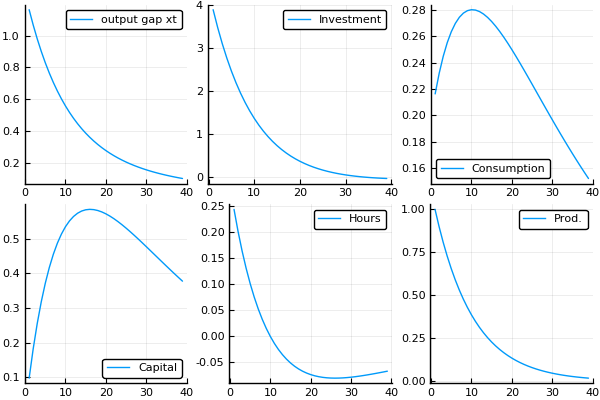

In [65]:
using Plots
pyplot()

nb_periods = 40
x = zeros(6, nb_periods)
u = zeros(6, nb_periods)
#initialization
u[:,1] = [0.0 0.0 0.0 0.0 0.0 1.0]

for t=2:nb_periods
    # Law of motion
    x[:,t] = F * x[:,t-1] + Q * u[:,t-1]
end

p1 = plot(x[1,2:end], label = "output gap xt")
p2 = plot(x[2,2:end], label = "Investment")
p3 = plot(x[3,2:end], label = "Consumption")
p4 = plot(x[4,2:end], label = "Capital")
p5 = plot(x[5,2:end], label = "Hours")
p6 = plot(x[6,2:end], label = "Prod.")
p = plot(p1,p2, p3, p4, p5, p6)

## Stochastic Simulation 

We can also generate a series of draws from $e_t$ to simulate an economy and calculate moments on the simulated
series:

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1192


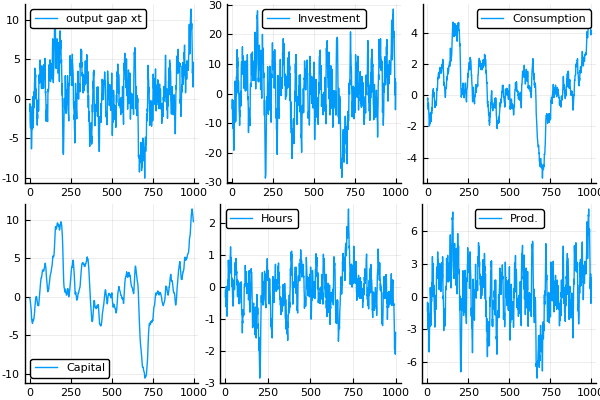

In [72]:
# Calculate a stochastic simulation
using Distributions
d = Normal()

nb_periods = 1000
x = zeros(6, nb_periods)
u = zeros(6, nb_periods)
#initialization
u[6,:] = rand(d, nb_periods) #series of shocks

for t=2:nb_periods
    # Law of motion
    x[:,t] = F * x[:,t-1] + Q * u[:,t-1]
end

p1 = plot(x[1,2:end], label = "output gap xt")
p2 = plot(x[2,2:end], label = "Investment")
p3 = plot(x[3,2:end], label = "Consumption")
p4 = plot(x[4,2:end], label = "Capital")
p5 = plot(x[5,2:end], label = "Hours")
p6 = plot(x[6,2:end], label = "Prod.")
p = plot(p1,p2, p3, p4, p5, p6)

In [82]:
#correlation matrix
cor(transpose(x[:,2:end]),transpose(x[:,2:end]))

6×6 Array{Float64,2}:
 1.0       0.954544   0.842972   0.712213   0.200527  0.979622
 0.954544  1.0        0.644305   0.470603   0.483428  0.99496 
 0.842972  0.644305   1.0        0.978002  -0.357991  0.717745
 0.712213  0.470603   0.978002   1.0       -0.544888  0.556709
 0.200527  0.483428  -0.357991  -0.544888   1.0       0.393212
 0.979622  0.99496    0.717745   0.556709   0.393212  1.0     

## Conclusion

This post illustrated how one can solve the neoclassical growth model from scratch, using Linear Time
Iteration. While the model presented here is quite simple, the three-step approach discussed is quite general.

## References

* Rendahl, Pontus. Linear time iteration. No. 330. IHS Economics Series, 2017.
(https://www.ihs.ac.at/publications/eco/es-330.pdf)
* The original Matlab code is available [here](https://sites.google.com/site/pontusrendahl/Research)